In [2]:
import os
import h5py
import numpy as np


data_folder = '/kaggle/input'

meningioma_count = 0
glioma_count = 0
pituitary_count = 0

processed_files = set()

def process_mat_file(file_path):
    global meningioma_count, glioma_count, pituitary_count
    with h5py.File(file_path, 'r') as mat_data:

        tumor_label = mat_data['cjdata']['label'][()]
        if tumor_label == 1:
            meningioma_count += 1
        elif tumor_label == 2:
            glioma_count += 1
        elif tumor_label == 3:
            pituitary_count += 1


for root, _, files in os.walk(data_folder):
    for file in files:
        if file.endswith(".mat") and file not in processed_files:
            file_path = os.path.join(root, file)
            process_mat_file(file_path)
            processed_files.add(file)

print(f"Meningioma: {meningioma_count} images")
print(f"Glioma: {glioma_count} images")
print(f"Pituitary: {pituitary_count} images")


Meningioma: 708 images
Glioma: 1426 images
Pituitary: 930 images


In [3]:
import os
import h5py
import numpy as np
from skimage.transform import resize

images = []
masks = []
labels = []

img_size_target = 128  # Target image size

processed_files_count = 0

for root, dirs, files in os.walk(data_folder):
    for file in files:
        if file.endswith(".mat"):
            file_path = os.path.join(root, file)

            with h5py.File(file_path, 'r') as mat_data:
                image_data = mat_data['cjdata']['image'][()]
                tumor_mask = mat_data['cjdata']['tumorMask'][()]
                tumor_label = mat_data['cjdata']['label'][()]

                if tumor_label.ndim > 0:
                    tumor_label = tumor_label.item()

                
                if image_data.shape != (512, 512):
                    print(f"Warning: Resizing image from {image_data.shape} to ({img_size_target}, {img_size_target})")

                image_resized = resize(image_data, (img_size_target, img_size_target), mode='constant', preserve_range=True)
                mask_resized = resize(tumor_mask, (img_size_target, img_size_target), mode='constant', preserve_range=True)

                image_resized = np.expand_dims(image_resized, axis=-1)
                mask_resized = np.expand_dims(mask_resized, axis=-1)

                images.append(image_resized)
                masks.append(mask_resized)
                labels.append(tumor_label - 1)

                processed_files_count += 1

images = np.array(images)
masks = np.array(masks)
labels = np.array(labels)

print(f"Total processed files: {processed_files_count}")
print(f"Images shape: {images.shape}")
print(f"Masks shape: {masks.shape}")
print(f"Labels shape: {labels.shape}")


Total processed files: 3064
Images shape: (3064, 128, 128, 1)
Masks shape: (3064, 128, 128, 1)
Labels shape: (3064,)


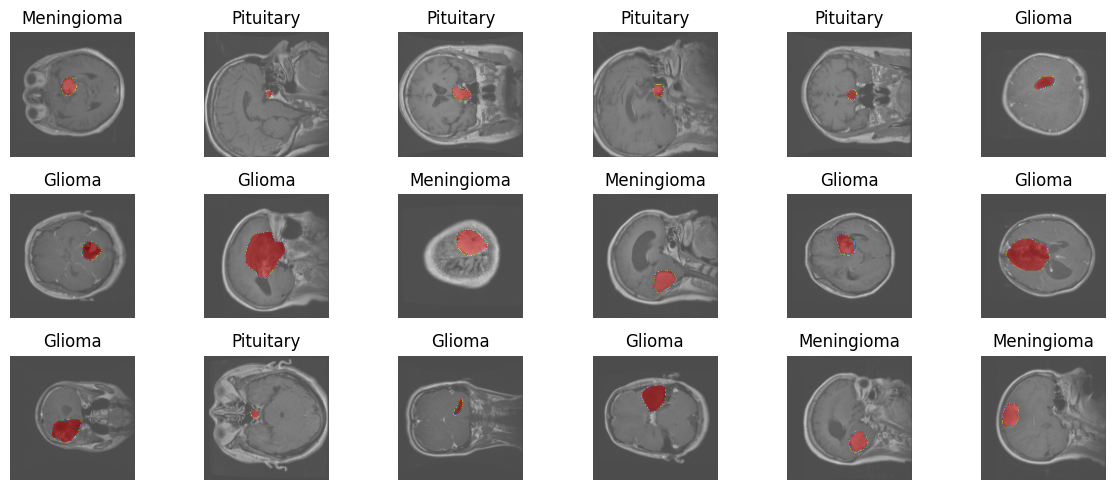

In [4]:
import matplotlib.pyplot as plt


integer_to_class = {
    0: 'Meningioma',
    1: 'Glioma',
    2: 'Pituitary'
}


plt.figure(figsize=(12, 5))
for i, idx in enumerate(np.random.randint(images.shape[0], size=18), start=1):
    plt.subplot(3, 6, i)
    plt.imshow(np.squeeze(images[idx], axis=-1), cmap='gray')
    plt.imshow(np.squeeze(np.ones_like(masks[idx]) - masks[idx], axis=-1), alpha=0.5, cmap='Set1')
    plt.title(integer_to_class[labels[idx]])
    plt.axis('off')

plt.tight_layout()
plt.show()


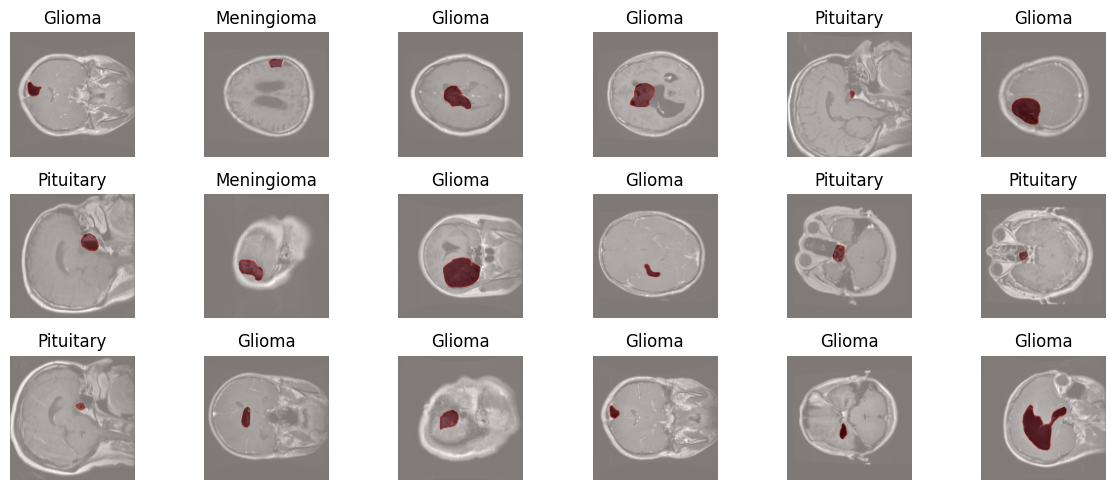

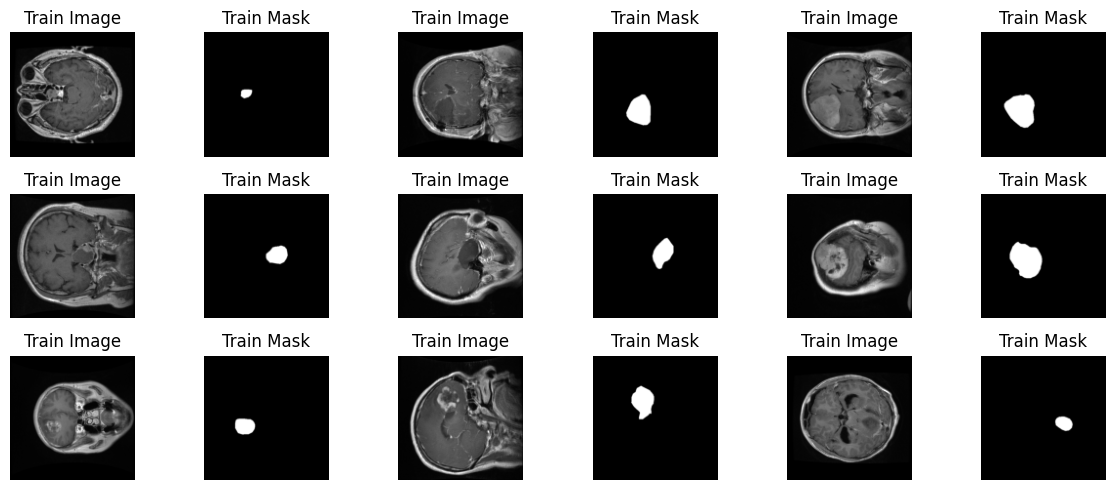

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Class Mapping
integer_to_class = {
    0: 'Meningioma',
    1: 'Glioma',
    2: 'Pituitary'
}

# First visualization: Overlay Images & Masks
plt.figure(figsize=(12, 5))
for i, idx in enumerate(np.random.randint(images.shape[0], size=18), start=1):
    plt.subplot(3, 6, i)
    plt.imshow(np.squeeze(images[idx], axis=-1), cmap='gray')  # Original Image
    plt.imshow(np.squeeze(masks[idx], axis=-1), alpha=0.5, cmap='Reds')  # Overlay Mask
    plt.title(integer_to_class[labels[idx]])
    plt.axis('off')

plt.tight_layout()
plt.show()

# Second visualization: Image-Mask Pairing
plt.figure(figsize=(12, 5))
i = 1
for idx in np.random.randint(images.shape[0], size=9):
    plt.subplot(3, 6, i)
    plt.imshow(np.squeeze(images[idx], axis=-1), cmap='gray')
    plt.title("Train Image")
    plt.axis('off')
    i += 1

    plt.subplot(3, 6, i)
    plt.imshow(np.squeeze(masks[idx], axis=-1), cmap='gray')
    plt.title("Train Mask")
    plt.axis('off')
    i += 1

plt.tight_layout()
plt.show()


In [7]:
from sklearn.model_selection import train_test_split


X_data, X_test, y_data, y_test, labels_data, labels_test = train_test_split(
    images, masks, labels, test_size=0.1, stratify=labels, random_state=42
)

# Print shapes of training and test sets
print("Training images shape:", X_data.shape)  
print("Test images shape:", X_test.shape)       

print("Training masks shape:", y_data.shape)   
print("Test masks shape:", y_test.shape)        

print("Training labels shape:", labels_data.shape)   
print("Test labels shape:", labels_test.shape)  


Training images shape: (2757, 128, 128, 1)
Test images shape: (307, 128, 128, 1)
Training masks shape: (2757, 128, 128, 1)
Test masks shape: (307, 128, 128, 1)
Training labels shape: (2757,)
Test labels shape: (307,)


In [9]:

X_train, X_val, y_train, y_val, labels_train, labels_val = train_test_split(
    X_data, y_data, labels_data, test_size=0.2, stratify=labels_data, random_state=42
)

# Print shapes of training, validation, and test sets
print("Training images shape:", X_train.shape)  
print("Validation images shape:", X_val.shape)  
print("Test images shape:", X_test.shape)       

print("Training masks shape:", y_train.shape)   
print("Validation masks shape:", y_val.shape)   
print("Test masks shape:", y_test.shape)        

print("Training labels shape:", labels_train.shape)   
print("Validation labels shape:", labels_val.shape)   
print("Test labels shape:", labels_test.shape)  


Training images shape: (2205, 128, 128, 1)
Validation images shape: (552, 128, 128, 1)
Test images shape: (307, 128, 128, 1)
Training masks shape: (2205, 128, 128, 1)
Validation masks shape: (552, 128, 128, 1)
Test masks shape: (307, 128, 128, 1)
Training labels shape: (2205,)
Validation labels shape: (552,)
Test labels shape: (307,)


In [10]:
X_train_aug = np.append( X_train, [np.fliplr(x) for x in X_train], axis=0 )
y_train_aug = np.append( y_train, [np.fliplr(y) for y in y_train], axis=0 )
X_train_aug.shape,y_train_aug.shape

((4410, 128, 128, 1), (4410, 128, 128, 1))

In [11]:

print("Training images shape:", X_train_aug.shape)  
print("Training masks shape:", y_train_aug.shape)    
print("Validation images shape:", X_val.shape) 
print("Validation masks shape:", y_val.shape)    


Training images shape: (4410, 128, 128, 1)
Training masks shape: (4410, 128, 128, 1)
Validation images shape: (552, 128, 128, 1)
Validation masks shape: (552, 128, 128, 1)


In [12]:
def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = tf.keras.backend.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = tf.keras.backend.flatten(tf.cast(y_pred, tf.float32))
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    score = (2.0 * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)
    return 1 - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

In [13]:
import tensorflow as tf
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, Input, BatchNormalization
from keras import optimizers
from keras.models import Model
from keras import backend as K
from keras.losses import binary_crossentropy

IMG_DIM = (128, 128, 1)

def conv2d_block(input_tensor, n_filters, kernel_size=(3, 3), name="contraction"):
    x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal',
               padding='same', activation="relu", name=name + '_1')(input_tensor)
    x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal',
               padding='same', activation="relu", name=name + '_2')(x)
    return x


inp = Input(shape=IMG_DIM)

d1 = conv2d_block(inp, 64, name="contraction_1")
p1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(d1)
p1 = BatchNormalization(momentum=0.8)(p1)
p1 = Dropout(0.1)(p1)

d2 = conv2d_block(p1, 128, name="contraction_2")
p2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(d2)
p2 = BatchNormalization(momentum=0.8)(p2)
p2 = Dropout(0.1)(p2)

d3 = conv2d_block(p2, 256, name="contraction_3")
p3 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(d3)
p3 = BatchNormalization(momentum=0.8)(p3)
p3 = Dropout(0.1)(p3)

d4 = conv2d_block(p3, 512, name="contraction_4")
p4 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))(d4)
p4 = BatchNormalization(momentum=0.8)(p4)
p4 = Dropout(0.1)(p4)

d5 = conv2d_block(p4, 512, name="contraction_5")

u1 = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(d5)
u1 = concatenate([u1, d4])
u1 = Dropout(0.1)(u1)
c1 = conv2d_block(u1, 512, name="expansion_1")

u2 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(c1)
u2 = concatenate([u2, d3])
u2 = Dropout(0.1)(u2)
c2 = conv2d_block(u2, 256, name="expansion_2")

u3 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c2)
u3 = concatenate([u3, d2])
u3 = Dropout(0.1)(u3)
c3 = conv2d_block(u3, 128, name="expansion_3")

u4 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c3)
u4 = concatenate([u4, d1])
u4 = Dropout(0.1)(u4)
c4 = conv2d_block(u4, 64, name="expansion_4")

out = Conv2D(1, (1, 1), name="output", activation='sigmoid')(c4)

unet = Model(inp, out)
unet.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ contraction_1_1 (Conv2D)  │ (None, 128, 128, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ contraction_1_2 (Conv2D)  │ (None, 128, 128, 64)   │         36,928 │ contraction_1_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 64, 64, 64)     │              0 │ contraction_1_2[0][0]  │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 64, 64, 64)     │            256 │ max_pooling2d[0][0]    │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 64, 64, 64)     │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ contraction_2_1 (Conv2D)  │ (None, 64, 64, 128)    │         73,856 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ contraction_2_2 (Conv2D)  │ (None, 64, 64, 128)    │        147,584 │ contraction_2_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 128)    │              0 │ contraction_2_2[0][0]  │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 32, 32, 128)    │            512 │ max_pooling2d_1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32, 32, 128)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ contraction_3_1 (Conv2D)  │ (None, 32, 32, 256)    │        295,168 │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ contraction_3_2 (Conv2D)  │ (None, 32, 32, 256)    │        590,080 │ contraction_3_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 16, 16, 256)    │              0 │ contraction_3_2[0][0]  │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 16, 16, 256)    │          1,024 │ max_pooling2d_2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 16, 16, 256)    │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ contraction_4_1 (Conv

 Total params: 22,718,529 (86.66 MB)

 Trainable params: 22,716,609 (86.66 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [15]:

def iou_metric(y_true, y_pred):
    y_pred = tf.cast(y_pred > 0.5, tf.float32)
    y_true = tf.cast(y_true, tf.float32)

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + 1e-10) / (union + 1e-10)

    return iou
unet.compile(optimizer=optimizers.Adam(learning_rate=1e-3,),
             loss=bce_dice_loss, metrics=['accuracy', iou_metric])


In [16]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model
from sklearn.preprocessing import LabelEncoder

model_checkpoint = ModelCheckpoint('model_best_checkpoint.keras', save_best_only=True,
                                   monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, mode='min', verbose=1)
reduce_lr = ReduceLROnPlateau(patience=4, verbose=2, monitor='val_loss', min_lr=1e-4, mode='min')

callback_list = [early_stopping, reduce_lr, model_checkpoint]

hist = unet.fit(X_train_aug, y_train_aug, batch_size=16, epochs=50,
               validation_data=(X_val, y_val), verbose=1, callbacks=callback_list)

unet = load_model('model_best_checkpoint.keras', custom_objects={'bce_dice_loss': bce_dice_loss, 'iou_metric': iou_metric}, compile=False)

Epoch 1/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 326ms/step - accuracy: 0.9367 - iou_metric: 0.0237 - loss: 19.4930
Epoch 1: val_loss improved from inf to 1.05933, saving model to model_best_checkpoint.keras
276/276 ━━━━━━━━━━━━━━━━━━━━ 153s 407ms/step - accuracy: 0.9367 - iou_metric: 0.0238 - loss: 19.4427 - val_accuracy: 0.9572 - val_iou_metric: 0.1281 - val_loss: 1.0593 - learning_rate: 0.0010
Epoch 2/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9640 - iou_metric: 0.1280 - loss: 1.0797
Epoch 2: val_loss improved from 1.05933 to 0.74272, saving model to model_best_checkpoint.keras
276/276 ━━━━━━━━━━━━━━━━━━━━ 67s 242ms/step - accuracy: 0.9640 - iou_metric: 0.1281 - loss: 1.0793 - val_accuracy: 0.9699 - val_iou_metric: 0.2718 - val_loss: 0.7427 - learning_rate: 0.0010
Epoch 3/50
276/276 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step - accuracy: 0.9732 - iou_metric: 0.3039 - loss: 0.6830
Epoch 3: val_loss improved from 0.74272 to 0.55037, saving model to model_best_checkpoint.keras
276/27

In [17]:
unet.save("/kaggle/working/model_best_checkpoint.keras")


In [ ]:
from keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

# Load the trained U-Net model
unet = load_model("/kaggle/working/model_best_checkpoint.keras", 
                  custom_objects={'bce_dice_loss': bce_dice_loss, 'iou_metric': iou_metric}, 
                  compile=False)


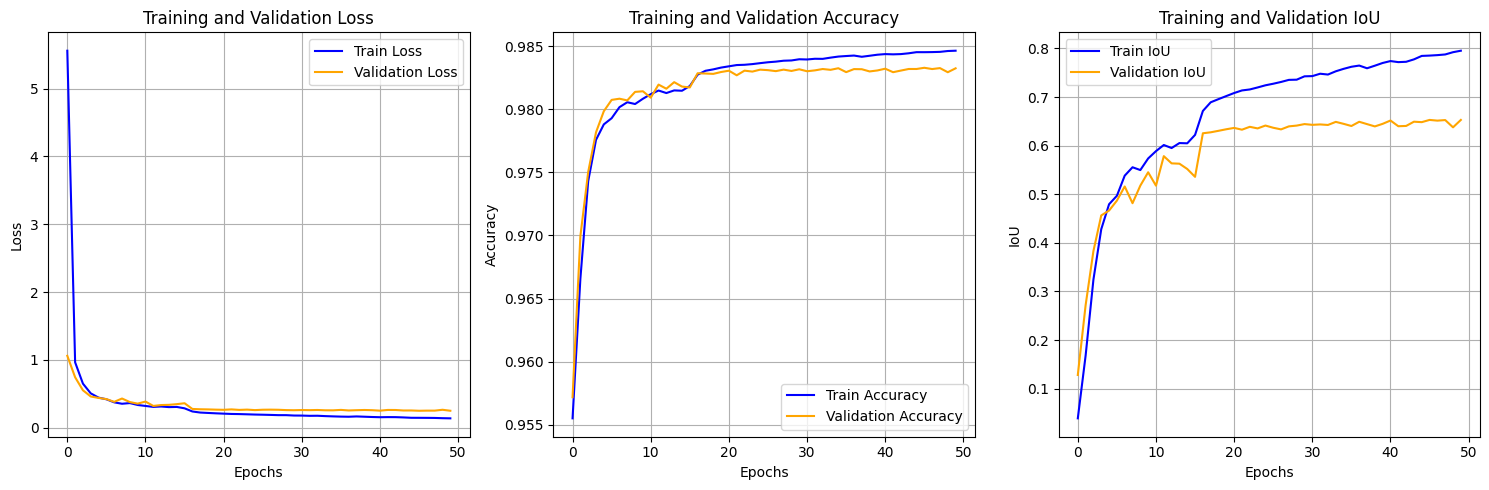

In [18]:
import matplotlib.pyplot as plt

train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_accuracy = hist.history.get('accuracy')
val_accuracy = hist.history.get('val_accuracy')
train_iou = hist.history.get('iou_metric')
val_iou = hist.history.get('val_iou_metric')


plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(val_loss, label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()


plt.subplot(1, 3, 2)
if train_accuracy is not None and val_accuracy is not None:
    plt.plot(train_accuracy, label='Train Accuracy', color='blue')
    plt.plot(val_accuracy, label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
else:
    print("Accuracy metrics are not available in the history.")

plt.subplot(1, 3, 3)
if train_iou is not None and val_iou is not None:
    plt.plot(train_iou, label='Train IoU', color='blue')
    plt.plot(val_iou, label='Validation IoU', color='orange')
    plt.title('Training and Validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()
    plt.grid()
else:
    print("IoU metrics are not available in the history.")

plt.tight_layout()
plt.show()


In [19]:
def get_iou_vector(A, B):
    t = A>0
    p = B>0
    intersection = np.logical_and(t,p)
    union = np.logical_or(t,p)
    iou = (np.sum(intersection) + 1e-10 )/ (np.sum(union) + 1e-10)
    return iou

def getIOUCurve(mask_org,predicted):
  thresholds = np.linspace(0, 1, 100)
  ious = np.array([get_iou_vector(mask_org, predicted > threshold) for threshold in thresholds])
  thres_best_index = np.argmax(ious[9:-10]) + 9
  iou_best = ious[thres_best_index]
  thres_best = thresholds[thres_best_index]
  return thresholds,ious,iou_best,thres_best

In [20]:
unet.compile(optimizer=optimizers.Adam(learning_rate=1e-3,),
             loss=bce_dice_loss, metrics=['accuracy', iou_metric])


loss, accuracy, iou = unet.evaluate(X_val, y_val)


print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")
print(f"Validation IoU: {iou:.4f}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 21s 149ms/step - accuracy: 0.9833 - iou_metric: 0.6772 - loss: 0.2291
Validation Loss: 0.2477
Validation Accuracy: 0.9833
Validation IoU: 0.6490


In [21]:

y_pred = unet.predict(X_val)

best_thresholds = []
best_ious = []


for i in range(len(y_val)):
    thresholds, ious, iou_best, thres_best = getIOUCurve(y_val[i], y_pred[i])
    best_thresholds.append(thres_best)
    best_ious.append(iou_best)


optimal_threshold = np.mean(best_thresholds)
print(f"Optimal threshold: {optimal_threshold:.4f}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 150ms/step
Optimal threshold: 0.1524


In [22]:
def dice_coefficient(y_true, y_pred, threshold=0.1524):
    y_pred_bin = (y_pred > threshold).astype(np.uint8)
    intersection = np.sum(y_true * y_pred_bin)
    return (2. * intersection) / (np.sum(y_true) + np.sum(y_pred_bin) + 1e-10)

dice_scores = [dice_coefficient(y_val[i], unet.predict(np.expand_dims(X_val[i], axis=0))[0]) for i in range(len(X_val))]
print(f"Mean Dice Coefficient: {np.mean(dice_scores):.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━

In [23]:
def precision_recall_f1(y_true, y_pred, threshold=0.1524):
    y_pred_bin = (y_pred > threshold).astype(np.uint8)

    TP = np.sum(y_true * y_pred_bin)  
    FP = np.sum((1 - y_true) * y_pred_bin)  
    FN = np.sum(y_true * (1 - y_pred_bin)) 

    precision = TP / (TP + FP + 1e-10)
    recall = TP / (TP + FN + 1e-10)
    f1_score = 2 * (precision * recall) / (precision + recall + 1e-10)

    return precision, recall, f1_score

metrics = [precision_recall_f1(y_val[i], unet.predict(np.expand_dims(X_val[i], axis=0))[0]) for i in range(len(X_val))]
precisions, recalls, f1_scores = zip(*metrics)

print(f"Mean Precision: {np.mean(precisions):.4f}")
print(f"Mean Recall: {np.mean(recalls):.4f}")
print(f"Mean F1 Score: {np.mean(f1_scores):.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step


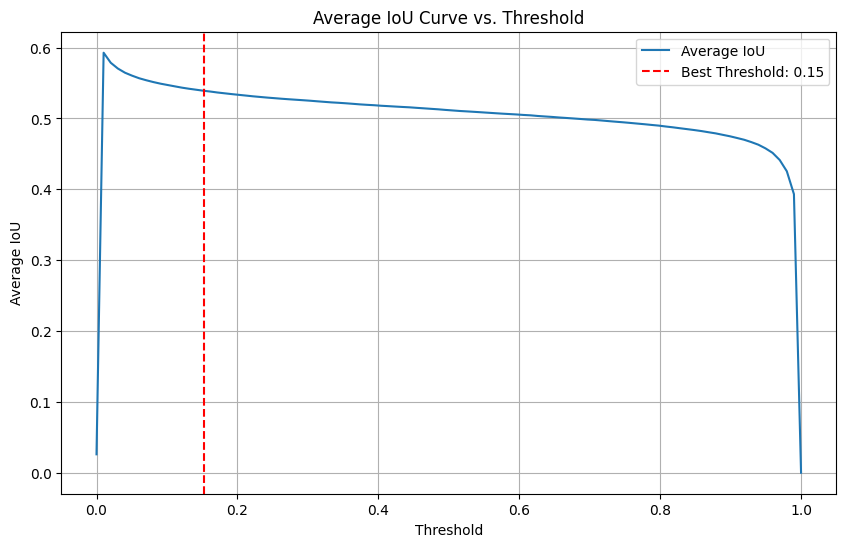

Average Best Threshold: 0.15


In [24]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf


predictions = unet.predict(X_val)


def get_iou_vector(A, B):
    t = A > 0
    p = B > 0
    intersection = np.logical_and(t, p)
    union = np.logical_or(t, p)
    iou = (np.sum(intersection) + 1e-10) / (np.sum(union) + 1e-10)
    return iou


def getIOUCurve(mask_org, predicted):
    thresholds = np.linspace(0, 1, 100)
    ious = np.array([get_iou_vector(mask_org, predicted > threshold) for threshold in thresholds])
    thres_best_index = np.argmax(ious[9:-10]) + 9  
    iou_best = ious[thres_best_index]
    thres_best = thresholds[thres_best_index]
    return thresholds, ious, iou_best, thres_best


ious_all = []
best_thresholds = []

for i in range(len(X_val)):
    mask_org = y_val[i].squeeze()  
    predicted = predictions[i].squeeze()  

    thresholds, ious, iou_best, thres_best = getIOUCurve(mask_org, predicted)
    ious_all.append(ious)
    best_thresholds.append(thres_best)


average_ious = np.mean(ious_all, axis=0)


plt.figure(figsize=(10, 6))
plt.plot(thresholds, average_ious, label="Average IoU")
plt.axvline(x=np.mean(best_thresholds), color='r', linestyle='--', label=f"Best Threshold: {np.mean(best_thresholds):.2f}")
plt.title("Average IoU Curve vs. Threshold")
plt.xlabel("Threshold")
plt.ylabel("Average IoU")
plt.legend()
plt.grid(True)
plt.show()

# Output the average best threshold
print(f"Average Best Threshold: {np.mean(best_thresholds):.2f}")


In [25]:
from sklearn.metrics import roc_auc_score
import numpy as np


y_pred = unet.predict(X_val)  


y_true_flat = (y_val > 0.1524).astype(np.uint8).flatten()  
y_pred_flat = y_pred.flatten()  


roc_auc = roc_auc_score(y_true_flat, y_pred_flat)

print(f"ROC AUC Score: {roc_auc:.4f}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step
ROC AUC Score: 0.9945


In [26]:
def sensitivity_specificity(y_true, y_pred, threshold=0.1524):
    y_pred_bin = (y_pred > threshold).astype(np.uint8)

    TP = np.sum(y_true * y_pred_bin)  
    FP = np.sum((1 - y_true) * y_pred_bin)  
    FN = np.sum(y_true * (1 - y_pred_bin)) 
    TN = np.sum((1 - y_true) * (1 - y_pred_bin))  

    sensitivity = TP / (TP + FN + 1e-10)  
    specificity = TN / (TN + FP + 1e-10)

    return sensitivity, specificity


metrics = [sensitivity_specificity(y_val[i], unet.predict(np.expand_dims(X_val[i], axis=0))[0]) for i in range(len(X_val))]
sensitivities, specificities = zip(*metrics)

print(f"Mean Sensitivity (Recall): {np.mean(sensitivities):.4f}")
print(f"Mean Specificity: {np.mean(specificities):.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━

In [114]:
import numpy as np
import matplotlib.pyplot as plt
#modelunet = load_model('model_best_checkpoint.keras')


integer_to_class = {
    0: 'Meningioma',
    1: 'Glioma',
    2: 'Pituitary'
}

THRESHOLD =  0.1524
predicted_mask = (unet.predict(X_test) > THRESHOLD).astype(np.uint8)

total = 10
random_indices = np.random.choice(len(y_test), size=total, replace=False)  

plt.figure(figsize=(12, total * 3))
temp = np.ones_like(y_test[0])

for i, idx in enumerate(random_indices):
    tumor_name = integer_to_class[labels[idx]]  

    plt.subplot(total, 3, i * 3 + 1)
    plt.imshow(np.squeeze(X_test[idx], axis=-1), cmap='gray')
    plt.title(f"MRI Image\n{tumor_name}")
    plt.axis('off')

    plt.subplot(total, 3, i * 3 + 2)
    plt.imshow(np.squeeze(X_test[idx], axis=-1), cmap='gray')
    plt.imshow(np.squeeze(temp - y_test[idx], axis=-1), alpha=0.2, cmap='Set1')
    plt.title("Original Mask")
    plt.axis('off')

    plt.subplot(total, 3, i * 3 + 3)
    plt.imshow(np.squeeze(X_test[idx], axis=-1), cmap='gray')
    plt.imshow(np.squeeze(temp - predicted_mask[idx], axis=-1), alpha=0.2, cmap='Set1')
    plt.title("Predicted Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()


10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step


IndexError: list index out of range

<Figure size 1200x3000 with 0 Axes>

In [28]:

predictions = unet.predict(X_data)  
threshold = 0.1524
predicted_masks = (predictions > threshold).astype(np.uint8)


87/87 ━━━━━━━━━━━━━━━━━━━━ 18s 205ms/step


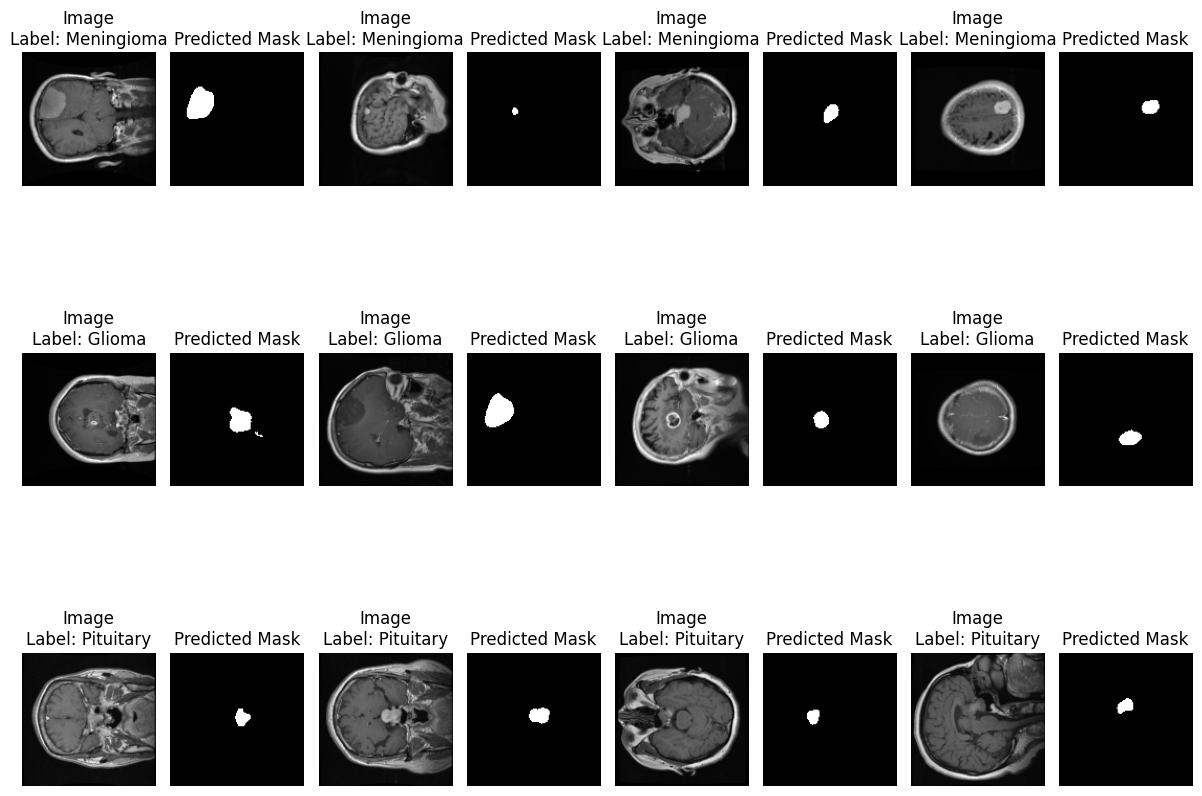

In [29]:
import matplotlib.pyplot as plt


integer_to_class = {
    0: 'Meningioma',
    1: 'Glioma',
    2: 'Pituitary'
}


meningioma_samples = [i for i in range(len(labels_data)) if labels_data[i] == 0][:4]
glioma_samples = [i for i in range(len(labels_data)) if labels_data[i] == 1][:4]
pituitary_samples = [i for i in range(len(labels_data)) if labels_data[i] == 2][:4]


plt.figure(figsize=(12, 10))


for i, idx in enumerate(meningioma_samples):
    plt.subplot(3, 8, i*2 + 1)  
    plt.imshow(np.squeeze(X_data[idx], axis=-1), cmap='gray')
    plt.title(f"Image\nLabel: {integer_to_class[labels_data[idx]]}")
    plt.axis('off')

    plt.subplot(3, 8, i*2 + 2)  
    plt.imshow(np.squeeze(predicted_masks[idx], axis=-1), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

# Glioma samples
for i, idx in enumerate(glioma_samples):
    plt.subplot(3, 8, (i+4)*2 + 1) 
    plt.imshow(np.squeeze(X_data[idx], axis=-1), cmap='gray')
    plt.title(f"Image\nLabel: {integer_to_class[labels_data[idx]]}")
    plt.axis('off')

    plt.subplot(3, 8, (i+4)*2 + 2)  
    plt.imshow(np.squeeze(predicted_masks[idx], axis=-1), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

# Pituitary samples
for i, idx in enumerate(pituitary_samples):
    plt.subplot(3, 8, (i+8)*2 + 1)  
    plt.imshow(np.squeeze(X_data[idx], axis=-1), cmap='gray')
    plt.title(f"Image\nLabel: {integer_to_class[labels_data[idx]]}")
    plt.axis('off')

    plt.subplot(3, 8, (i+8)*2 + 2)  
    plt.imshow(np.squeeze(predicted_masks[idx], axis=-1), cmap='gray')
    plt.title("Predicted Mask")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [30]:

print(f"Predicted Masks Shape: {predicted_masks.shape}")
print(f"Labels Shape: {labels_data.shape}")


Predicted Masks Shape: (2757, 128, 128, 1)
Labels Shape: (2757,)


In [31]:

blank_masks_indices = len([i for i, mask in enumerate(predicted_masks) if np.sum(mask) == 0])


if blank_masks_indices:
    print(f"Found blank predicted masks at indices: {blank_masks_indices}")
else:
    print("No blank predicted masks found.")


Found blank predicted masks at indices: 83


In [32]:

non_blank_indices = [i for i, mask in enumerate(predicted_masks) if np.sum(mask) > 0]


filtered_predicted_masks = predicted_masks[non_blank_indices]
filtered_labels = labels_data[non_blank_indices]


print(f"Filtered Predicted Masks Shape: {filtered_predicted_masks.shape}")
print(f"Filtered Labels Shape: {filtered_labels.shape}")


Filtered Predicted Masks Shape: (2674, 128, 128, 1)
Filtered Labels Shape: (2674,)


In [56]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


CNNmodel = keras.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 1)),  
    layers.MaxPooling2D(2,2),  
    layers.Conv2D(64, (3,3), activation='relu'),  
    layers.MaxPooling2D(2,2), 
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),  
    layers.Flatten(),  
    layers.Dense(128, activation='relu'),  
    layers.Dropout(0.7), 
    layers.Dense(3, activation='softmax')  
])


CNNmodel.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,451 (12.61 MB)

 Trainable params: 3,304,451 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [57]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


learning_rate = 0.001  


optimizer = Adam(learning_rate=learning_rate)


CNNmodel.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])


checkpoint_callback = ModelCheckpoint(
    'best_model.keras',  
    monitor='accuracy',  
    save_best_only=True,  
    verbose=1  
)


reduce_lr_callback = ReduceLROnPlateau(
    monitor='loss',  
    factor=0.2,  
    patience=3,  
    min_lr=0.0001,  
    verbose=1  
)


history1 = CNNmodel.fit(
  filtered_predicted_masks,  filtered_labels,
    epochs=30,
  
    batch_size=16,
    callbacks=[checkpoint_callback, reduce_lr_callback]  
)


CNNmodel.save('mri_tumor_classifier1.keras')  
print("Model saved successfully!")


Epoch 1/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6369 - loss: 0.8393
Epoch 1: accuracy improved from -inf to 0.67951, saving model to best_model.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6372 - loss: 0.8388 - learning_rate: 0.0010
Epoch 2/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7303 - loss: 0.6328
Epoch 2: accuracy improved from 0.67951 to 0.72625, saving model to best_model.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7303 - loss: 0.6328 - learning_rate: 0.0010
Epoch 3/30
161/168 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7557 - loss: 0.5962
Epoch 3: accuracy improved from 0.72625 to 0.75093, saving model to best_model.keras
168/168 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7555 - loss: 0.5961 - learning_rate: 0.0010
Epoch 4/30
162/168 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7763 - loss: 0.5442
Epoch 4: accuracy improved from 0.75093 to 0.77861, saving model to best_model.keras
168/168 ━━━━━━━━━━━━

In [68]:

test_loss1, test_accuracy1 = CNNmodel.evaluate(predicted_mask, labels_test)

print(f"Test Loss: {test_loss1}")
print(f"Test Accuracy: {test_accuracy1}")


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8252 - loss: 1.1046 
Test Loss: 1.0578442811965942
Test Accuracy: 0.837133526802063


In [69]:
import numpy as np


y_pred_prob1 = CNNmodel.predict(predicted_mask)


y_pred1 = np.argmax(y_pred_prob1, axis=1)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [76]:
from sklearn.metrics import classification_report


report1 = classification_report(labels_test, y_pred1, target_names=["Meningioma", "Glioma", "Pituitary"])

print(report1)


              precision    recall  f1-score   support

  Meningioma       0.72      0.66      0.69        71
      Glioma       0.86      0.84      0.85       143
   Pituitary       0.87      0.97      0.92        93

    accuracy                           0.84       307
   macro avg       0.82      0.82      0.82       307
weighted avg       0.83      0.84      0.83       307



In [72]:

print(type(labels_test))  
print(np.unique(labels_test))  


<class 'numpy.ndarray'>
[0. 1. 2.]


In [77]:
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(labels_test, y_pred1)


print("Confusion Matrix:")
print(cm)


Confusion Matrix:
[[ 47  17   7]
 [ 17 120   6]
 [  1   2  90]]


In [79]:

TP = np.diag(cm)  
FN = cm.sum(axis=1) - TP  
FP = cm.sum(axis=0) - TP 
TN = cm.sum() - (TP + FN + FP)  


accuracy_per_class = TP / (TP + FN)


target_names = ["Meningioma", "Glioma", "Pituitary"]  
for i in range(len(target_names)):
    print(f"Class: {target_names[i]}")
    print(f"True Positives (TP): {TP[i]}")
    print(f"False Negatives (FN): {FN[i]}")
    print(f"False Positives (FP): {FP[i]}")
    print(f"True Negatives (TN): {TN[i]}")
    print(f"Accuracy: {accuracy_per_class[i]:.4f}")
    print()


Class: Meningioma
True Positives (TP): 47
False Negatives (FN): 24
False Positives (FP): 18
True Negatives (TN): 218
Accuracy: 0.6620

Class: Glioma
True Positives (TP): 120
False Negatives (FN): 23
False Positives (FP): 19
True Negatives (TN): 145
Accuracy: 0.8392

Class: Pituitary
True Positives (TP): 90
False Negatives (FN): 3
False Positives (FP): 13
True Negatives (TN): 201
Accuracy: 0.9677



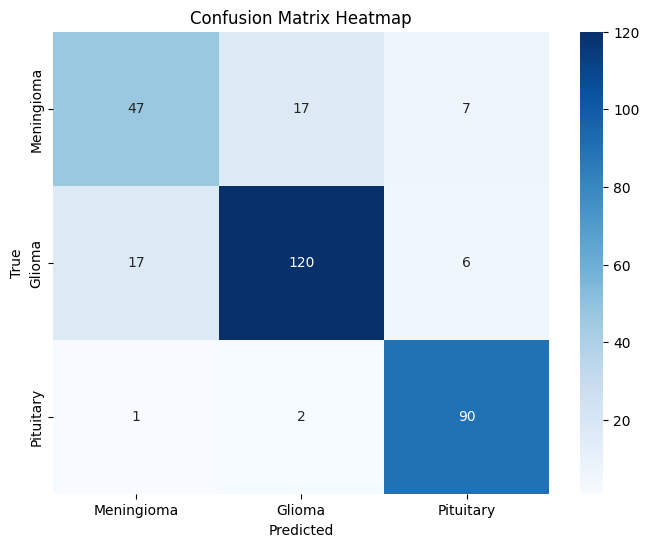

In [80]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix


cm = confusion_matrix(labels_test, y_pred1)

# Create a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()


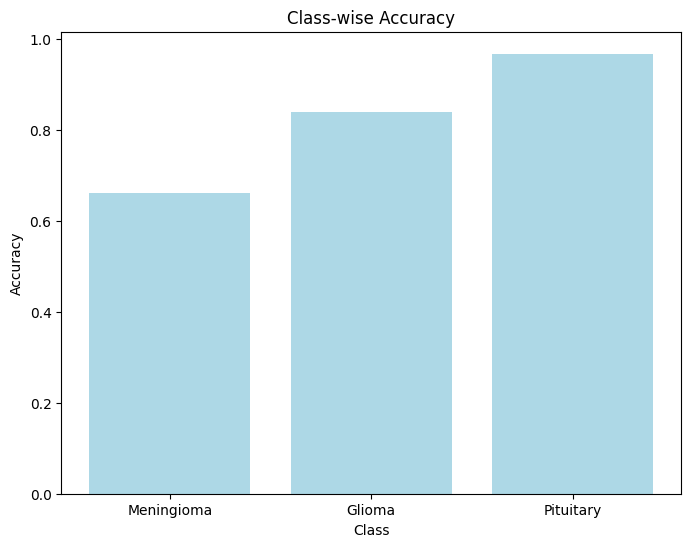

In [81]:
import numpy as np


class_accuracy = cm.diagonal() / cm.sum(axis=1)


plt.figure(figsize=(8, 6))
plt.bar(labels, class_accuracy, color='lightblue')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Class-wise Accuracy')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


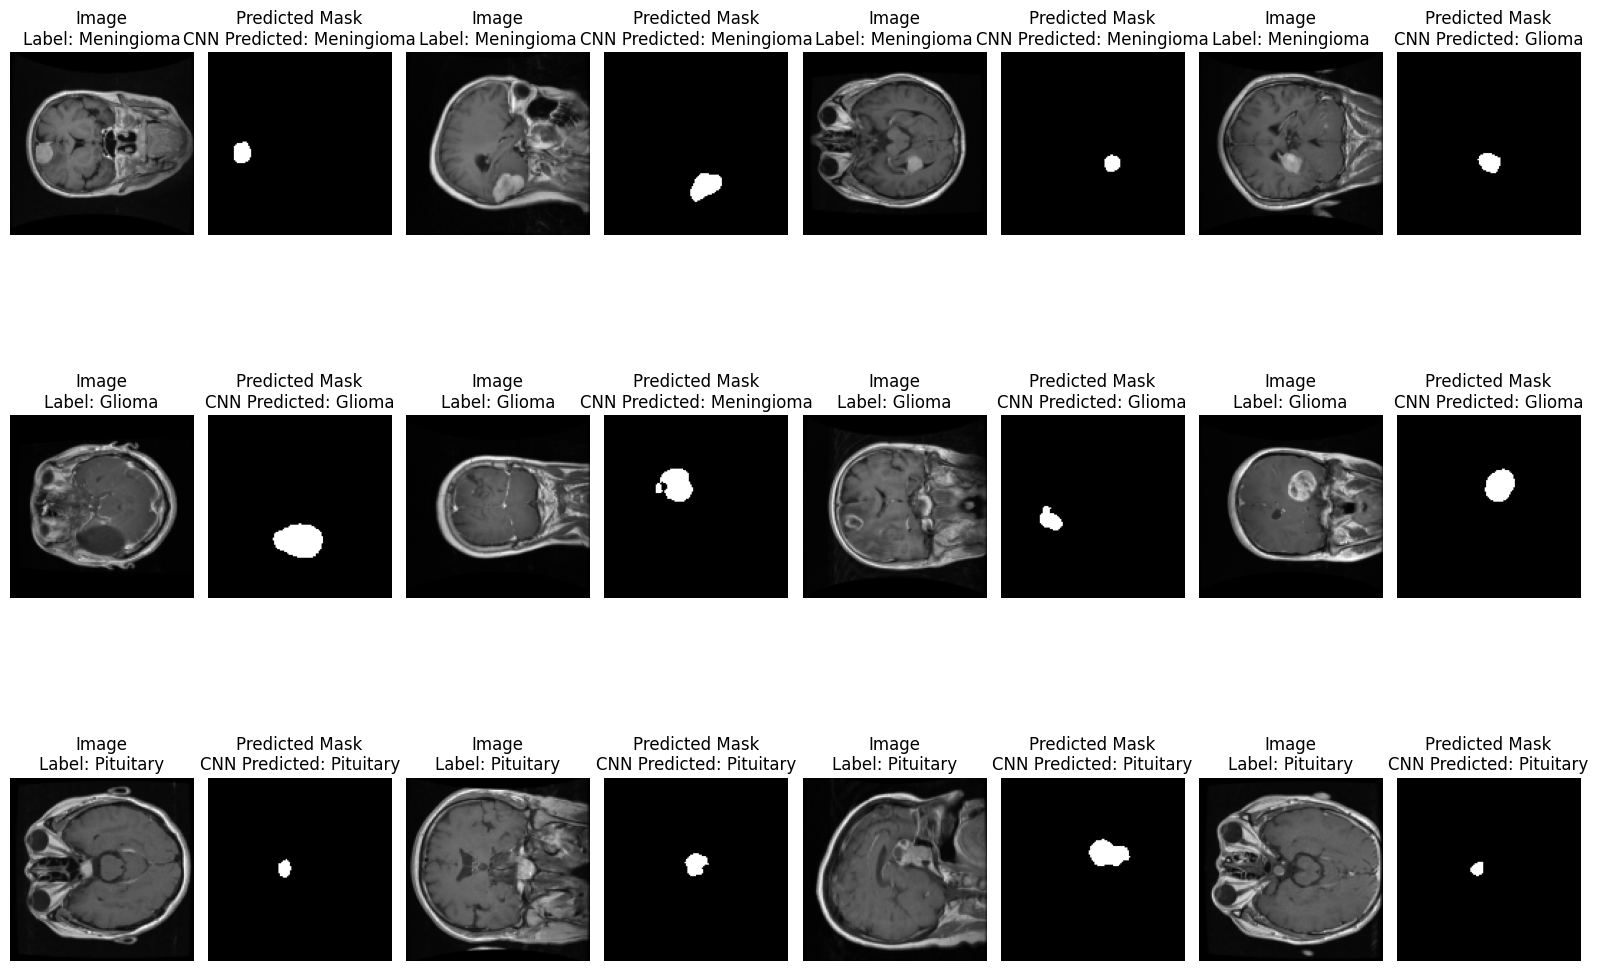

In [110]:
import matplotlib.pyplot as plt
import numpy as np


integer_to_class = {
    0: 'Meningioma',
    1: 'Glioma',
    2: 'Pituitary'
}


meningioma_samples = np.random.choice([i for i in range(len(labels_test)) if labels_test[i] == 0], 4, replace=False)
glioma_samples = np.random.choice([i for i in range(len(labels_test)) if labels_test[i] == 1], 4, replace=False)
pituitary_samples = np.random.choice([i for i in range(len(labels_test)) if labels_test[i] == 2], 4, replace=False)


plt.figure(figsize=(16, 12))


for i, idx in enumerate(meningioma_samples):
   
    plt.subplot(3, 8, i * 2 + 1)
    plt.imshow(np.squeeze(X_test[idx], axis=-1), cmap='gray')
    plt.title(f"Image\nLabel: {integer_to_class[labels_test[idx]]}")
    plt.axis('off')

    
    plt.subplot(3, 8, i * 2 + 2)
    plt.imshow(np.squeeze(predicted_mask[idx], axis=-1), cmap='gray')
    
    
    predicted_class = integer_to_class[np.argmax(CNNmodel.predict(np.expand_dims(predicted_mask[idx], axis=0)))] 
    plt.title(f"Predicted Mask\nCNN Predicted: {predicted_class}")
    plt.axis('off')


for i, idx in enumerate(glioma_samples):
    # Original Image (second row for Glioma)
    plt.subplot(3, 8, (i + 4) * 2 + 1)
    plt.imshow(np.squeeze(X_test[idx], axis=-1), cmap='gray')
    plt.title(f"Image\nLabel: {integer_to_class[labels_test[idx]]}")
    plt.axis('off')

    
    plt.subplot(3, 8, (i + 4) * 2 + 2)
    plt.imshow(np.squeeze(predicted_mask[idx], axis=-1), cmap='gray')
    
   
    predicted_class = integer_to_class[np.argmax(CNNmodel.predict(np.expand_dims(predicted_mask[idx], axis=0)))]  
    plt.title(f"Predicted Mask\nCNN Predicted: {predicted_class}")
    plt.axis('off')


for i, idx in enumerate(pituitary_samples):
   
    plt.subplot(3, 8, (i + 8) * 2 + 1)
    plt.imshow(np.squeeze(X_test[idx], axis=-1), cmap='gray')
    plt.title(f"Image\nLabel: {integer_to_class[labels_test[idx]]}")
    plt.axis('off')

   
    plt.subplot(3, 8, (i + 8) * 2 + 2)
    plt.imshow(np.squeeze(predicted_mask[idx], axis=-1), cmap='gray')
    
    
    predicted_class = integer_to_class[np.argmax(CNNmodel.predict(np.expand_dims(predicted_mask[idx], axis=0)))]  
    plt.title(f"Predicted Mask\nCNN Predicted: {predicted_class}")
    plt.axis('off')

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


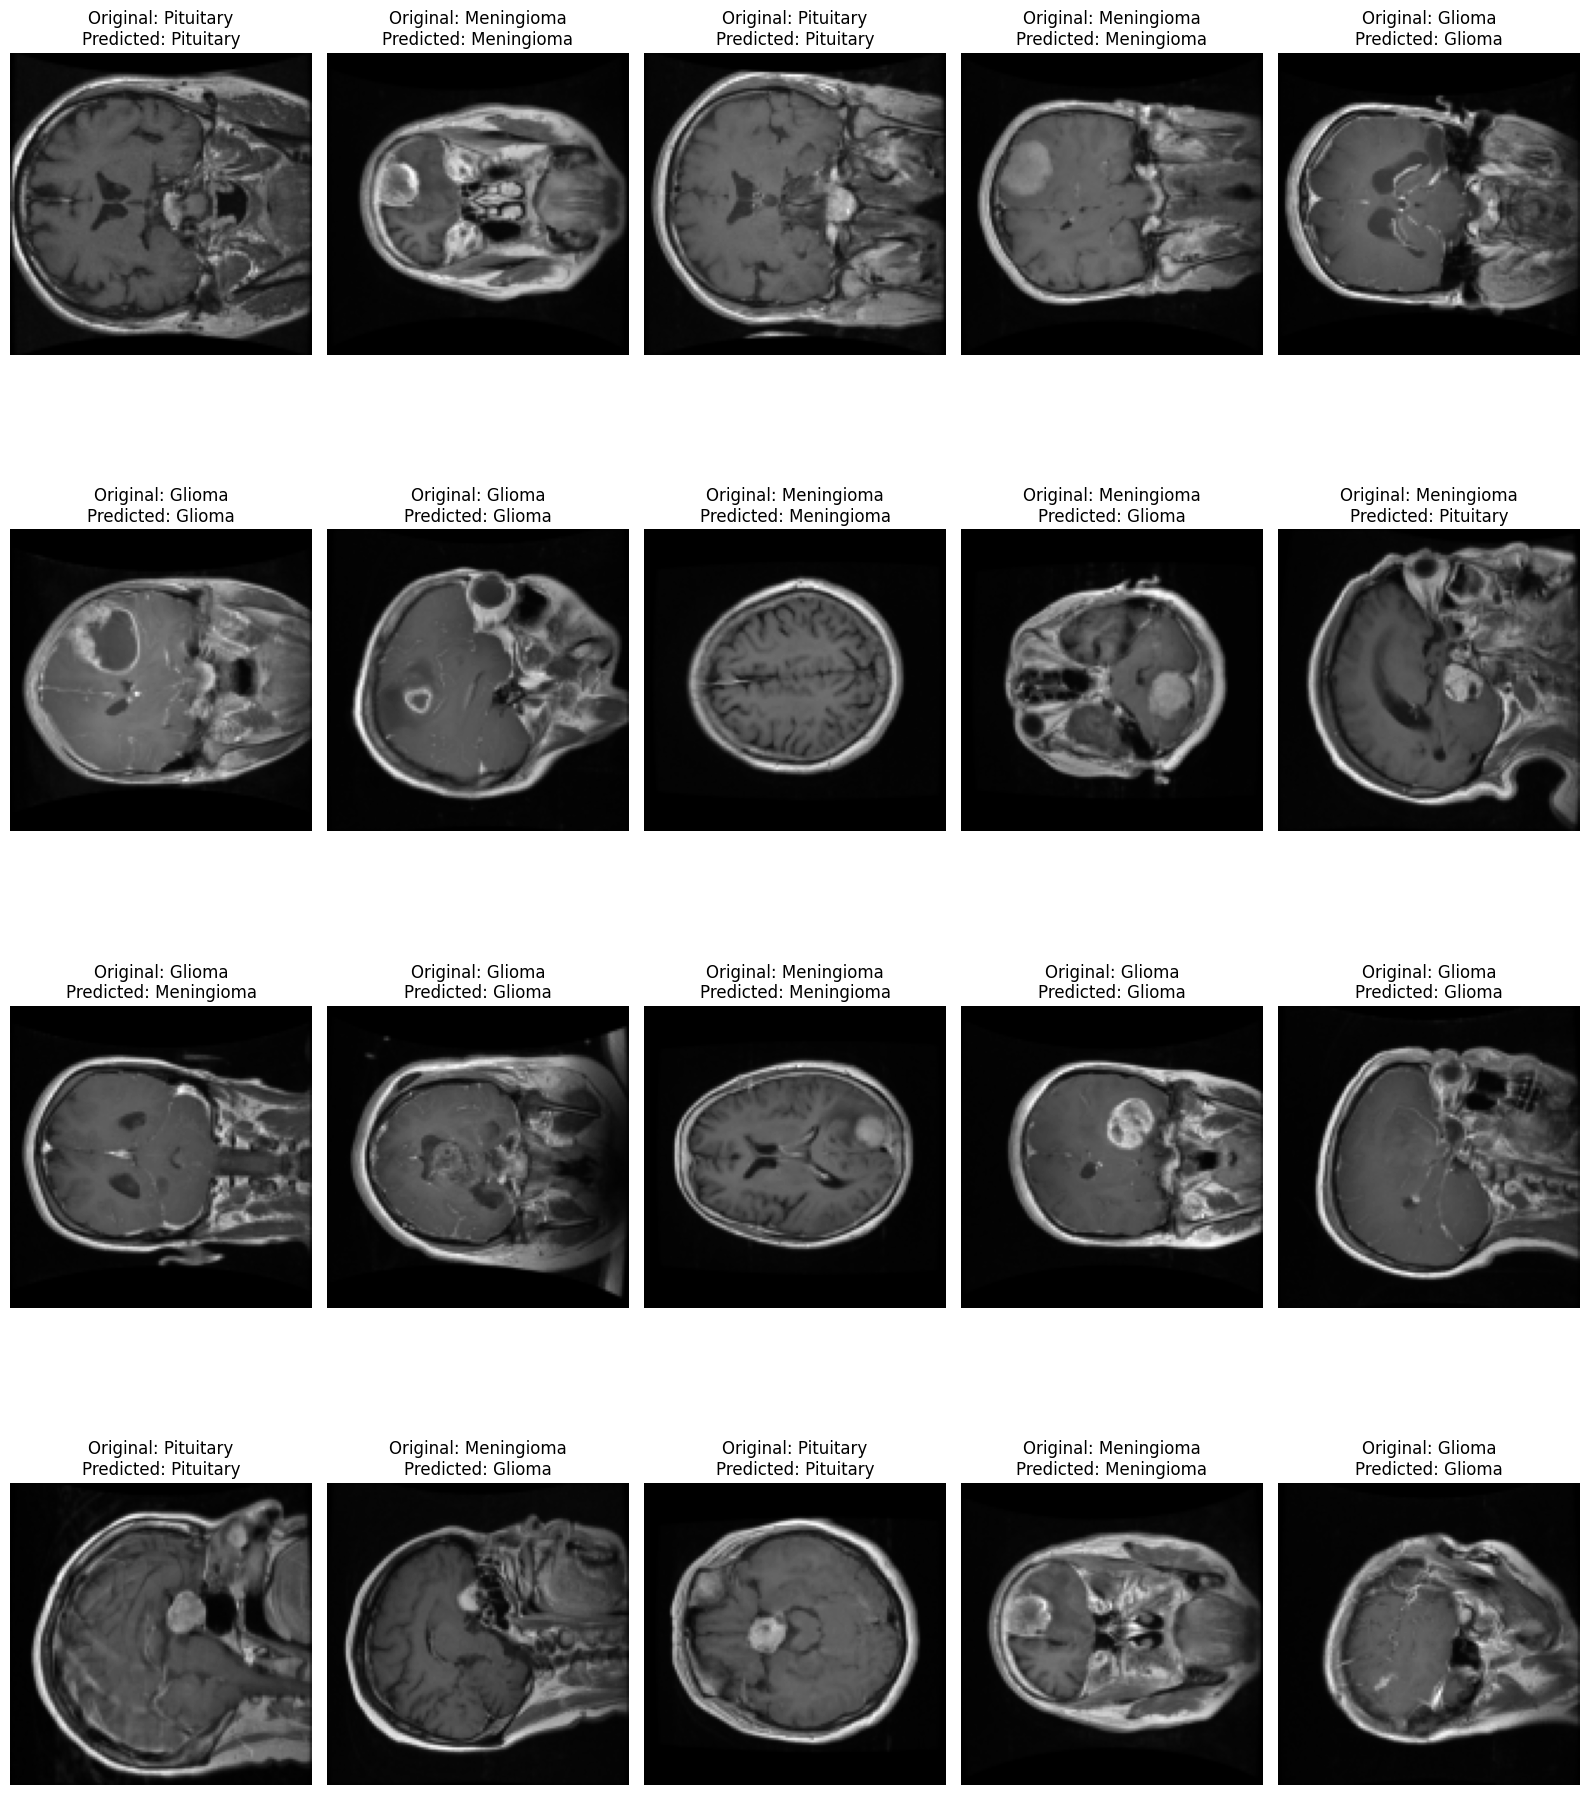

In [113]:
import matplotlib.pyplot as plt
import numpy as np


random_samples = np.random.choice(len(labels_test), 20, replace=False)


plt.figure(figsize=(16, 20))


for i, idx in enumerate(random_samples):
  
    plt.subplot(4, 5, i + 1)  
    plt.imshow(np.squeeze(X_test[idx], axis=-1), cmap='gray')
    
   
    original_label = integer_to_class[labels_test[idx]]  
    predicted_class = integer_to_class[np.argmax(CNNmodel.predict(np.expand_dims(predicted_mask[idx], axis=0)))]  
    plt.title(f"Original: {original_label}\nPredicted: {predicted_class}")
    plt.axis('off')

plt.tight_layout()
plt.show()
